In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /anaconda3/lib/python3.6/site-packages (18.1)


In [2]:
!pip install gensim

In [3]:
!pip install spacy

In [4]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
warnings.filterwarnings(action = 'ignore')
import gensim 
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet as wn
from sklearn.cluster import KMeans
import os

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nissani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nissani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nissani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nissani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
#train data
description_train = glob.glob("/Users/nissani/Desktop/data/descriptions_train/*.txt")
description_train_sort = sorted(description_train)

images_train = glob.glob("/Users/nissani/Desktop/data/images_train/*.jpg")
images_train_sort = sorted(images_train)

train_labels = os.listdir('/Users/nissani/Desktop/data/descriptions_train')
train_labels.pop(0)

#test data
description_test = glob.glob("/Users/nissani/Desktop/data/descriptions_test/*.txt")
description_test_sort = sorted(description_test)

images_test = glob.glob("/Users/nissani/Desktop/data/images_test/*.jpg")
images_test_sort = sorted(images_test)

test_labels = os.listdir('/Users/nissani/Desktop/data/descriptions_test')
test_labels.pop(0)

#Load tags and order
tags_train = glob.glob("/Users/nissani/Desktop/data/tags_train/*.txt")
tags_train_sort = sorted(tags_train)

all_tags = list()
for item in tags_train_sort:
    with open(item) as f:
        tags = f.read()
        all_tags.append(tags)

tags = []

for element in all_tags:
    helper = element.replace("\n", " ")
    helper = helper.replace(":", " ")
    tags.append(helper)

clean_tags = []

for element in tags:
    helper = element.split(" ")
    helper = list(filter(None, helper))
    clean_tags.append(helper)

category_tags =[]

for el in clean_tags:
    category_tags.append(el[1::2])

print(category_tags)

[['airplane', 'bench', 'skateboard', 'person', 'truck', 'backpack', 'handbag', 'dining'], ['bowl', 'carrot', 'spoon'], ['suitcase'], ['cake'], ['traffic'], ['cat'], ['airplane', 'person'], ['car', 'person', 'skis', 'handbag', 'traffic'], ['person', 'remote', 'couch'], ['boat', 'person', 'bird'], ['person', 'wine', 'kitchen', 'furniture', 'table'], ['baseball', 'sports', 'glove', 'person', 'bench'], ['person'], ['elephant'], ['couch', 'person', 'remote', 'book', 'chair', 'refrigerator'], ['bed', 'laptop', 'person'], ['motorcycle', 'person'], ['giraffe'], ['horse', 'person'], ['person'], ['traffic'], ['motorcycle', 'person'], ['car', 'bus', 'person'], ['person'], ['dining', 'kitchen', 'glass', 'spoon', 'bowl', 'pizza', 'cup'], ['airplane'], ['car', 'motorcycle'], ['train', 'person'], ['person', 'tennis'], ['bowl', 'broccoli', 'dining'], ['person', 'baseball'], ['elephant'], ['clock', 'person'], ['sports', 'person', 'sports', 'racket'], ['tv', 'mouse', 'keyboard'], ['person', 'backpack', 

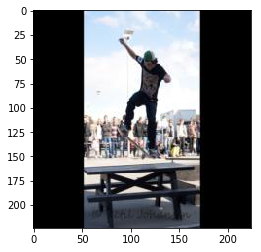

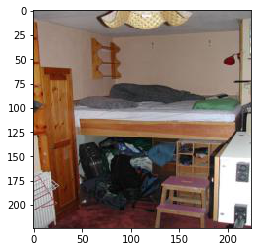

In [7]:
img=mpimg.imread(images_train_sort[0])
imgplot = plt.imshow(img)
plt.show()

img_test=mpimg.imread(images_test_sort[0])
imgplot_test = plt.imshow(img_test)
plt.show()

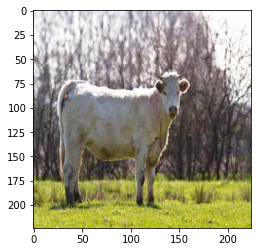

In [8]:
img=mpimg.imread(images_train_sort[1])
imgplot = plt.imshow(img)

img_test=mpimg.imread(images_test_sort[1])
imgplot = plt.imshow(img_test)

In [10]:
features_train = pd.read_csv("/Users/nissani/Desktop/data/features_train/features_resnet1000_train.csv")
features_train.head()

features_test = pd.read_csv("/Users/nissani/Desktop/data/features_test/features_resnet1000_test.csv")
features_test.head()

,images_test/152.jpg,-0.148756742477417,-0.4813389182090759,-0.6791373491287231,-2.8061068058013916,-1.2946584224700928,2.6951029300689697,-2.133972406387329,-0.1881876140832901,-0.5766686201095581,...,-1.443870186805725,-1.7984381914138794,-2.7966856956481934,1.5349980592727661,0.1443052738904953,1.9421441555023193,3.1954457759857178,-0.8703185319900513,3.440042495727539,-1.3466317653656006
0,images_test/901.jpg,-2.774335,-2.609678,-2.273406,-1.915194,-1.027429,2.151233,-2.217847,-0.296456,2.143005,...,-2.742686,-1.136329,-4.575315,1.765677,-2.347466,1.338462,2.915373,-2.641720,0.089083,-3.965153
1,images_test/1609.jpg,-4.703013,-3.121009,-0.720065,-2.328157,-3.979405,-1.072882,-4.729220,3.984846,1.935632,...,-2.210909,-0.393285,-2.162705,0.107424,-1.768499,1.311981,1.735954,-3.852225,2.147136,-1.664214
2,images_test/501.jpg,-4.720319,-3.283936,-3.425368,-0.901952,-1.317727,-1.849946,-6.023038,-3.963156,-2.675934,...,-2.049742,-3.026109,-4.674948,-3.972717,-1.293010,-2.171399,0.261835,-2.889009,-0.144852,4.513586
3,images_test/517.jpg,-2.542141,0.713983,-4.402996,-3.130132,-2.287015,-0.069825,-5.103557,-2.684636,-0.523625,...,1.023972,-4.033379,-2.397613,-1.837019,-4.435537,-1.170790,2.196201,-1.999686,2.442082,5.081684
4,images_test/1822.jpg,-0.458194,0.873834,-2.541110,-2.769785,-0.454619,-0.044429,-2.028427,-1.135319,-3.418399,...,-3.102760,-1.643083,-2.860882,-0.295628,0.756462,0.776443,3.885505,-0.183946,2.993125,-0.286729


In [11]:
features_train_array = features_train.values
features_test_array = features_test.values

In [12]:
image_names_train = []
image_features_train = []
for image in features_train_array:
    image_names_train.append(image[0])
    image_features_train.append(image[1:])
    
image_names_test = []
image_features_test = []
for image in features_test_array:
    image_names_test.append(image[0])
    image_features_test.append(image[1:])

In [13]:
image_names_train = np.array(image_names_train)
sorted_indices_train = np.argsort(image_names_train)
print(sorted_indices_train)

image_names_test = np.array(image_names_test)
sorted_indices_test = np.argsort(image_names_test)
print(sorted_indices_test)

[6643 2273 7719 ... 6180 1123 1224]
[ 522 1484 1568 ...   82  817  295]


In [14]:
image_features_train = np.array(image_features_train)
image_features_train = image_features_train[sorted_indices_train]
print(image_features_train[:10])

image_features_test = np.array(image_features_test)
image_features_test = image_features_test[sorted_indices_test]
print(image_features_test[:10])

[[-4.552913189 -3.339372635 0.7398045059999999 ... -4.325320721000001
  -1.3610081669999998 -0.184894502]
 [1.055799961 1.345919609 -4.62148428 ... -0.33549013699999997
  4.469384193 -0.193547025]
 [-1.601292133 -2.199482203 -0.254419595 ... -1.287298322
  -0.23897412399999998 -2.1438472269999997]
 ...
 [-4.258191109 -3.431674957 -1.8581144809999999 ... -4.952150822
  -1.7939039469999998 -1.813894629]
 [-0.25352728399999996 -0.5920935270000001 -1.7925578359999998 ...
  -3.4172170160000004 1.6602083440000002 -0.93057102]
 [1.727492929 0.312766731 -0.938245714 ... -1.169650197 0.708900392
  -2.245829105]]
[[-1.3306751251220703 0.27420181035995483 -1.102608323097229 ...
  -1.551756501197815 1.4819068908691406 0.21197134256362915]
 [0.17261110246181488 -2.4453234672546387 -1.3149980306625366 ...
  -1.6035648584365845 1.794989824295044 0.07138149440288544]
 [-1.384504795074463 -1.6751774549484253 -1.5897209644317627 ...
  -2.390776872634888 1.6812055110931396 -2.0798864364624023]
 ...
 [-0.

In [35]:
print(len(image_features_test))

1999


In [15]:
all_text = list()
for item in description_train_sort:
    with open(item) as f:
        text = f.read()
        all_text.append(text)
        
all_text_test = list()
for item in description_test_sort:
    with open(item) as f:
        text = f.read()
        all_text_test.append(text)

In [16]:
#lower case words
#for item in all_text:
all_text = map(lambda x: x.lower(), all_text)
all_text_test = map(lambda x: x.lower(), all_text_test)

# strip puntuation 
import re
all_text = map(lambda x: re.sub('['+string.punctuation+']', '', x), all_text)
all_text_test = map(lambda x: re.sub('['+string.punctuation+']', '', x), all_text_test)


#remove /n
all_text = map(lambda x: x.replace('\n', ' '), all_text)
all_text_test = map(lambda x: x.replace('\n', ' '), all_text_test)

    
all_text = list(all_text)
all_text_test = list(all_text_test)

In [69]:
#tfidf from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import string

tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
tfidf.fit(all_text)
response = tfidf.transform(all_text)
feature_names = tfidf.get_feature_names()

#tfidf_test = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
response_test = tfidf.transform(all_text_test)
feature_names_test = tfidf.get_feature_names()

#print non zero words
doc = 0
feature_index = response[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [response[doc, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

#final matrix
corpus_index = [n for n in all_text]
final_matrix = response.todense()
descriptions = corpus_index
feature_words = feature_names

#final matrix_test
corpus_index_test = [n for n in all_text_test]
final_matrix_test = response_test.todense()
descriptions_test = corpus_index_test
feature_words_test = feature_names_test

watching 0.1654819455572379
using 0.1664877228994022
tricks 0.199527589467428
trick 0.17516747097345872
table 0.27830601445224357
stage 0.25886623984317253
skateboarder 0.3158734991301988
skateboard 0.26950064140215224
skate 0.17451422857319746
riding 0.19838313546234856
putting 0.21607929443238091
pulling 0.18845909238875447
picnic 0.5332201580939814
person 0.1032815434838833
man 0.08564016199043656
doing 0.1663180048456758
crowd 0.16581389606731967
boarder 0.21915947883475032


In [70]:
final_matrix = np.array(final_matrix)
final_matrix_test = np.array(final_matrix_test)

In [71]:
print(final_matrix[1])

[0. 0. 0. ... 0. 0. 0.]


In [72]:
tdidf_shuffled = []

for i in range(5000):
    tdidf_shuffled.append(final_matrix[i])

In [73]:
final_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
import random

random_numbers = random.sample(range(5000), 5000)

for i in range(5000):
    tdidf_shuffled.append(final_matrix[random_numbers[i]])

In [75]:
tdidf_shuffled = np.array(tdidf_shuffled)
print(tdidf_shuffled)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [76]:
print(final_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [77]:
images_train = np.array(images_train)
print(images_train)

['/Users/nissani/Desktop/data/images_train/9733.jpg'
 '/Users/nissani/Desktop/data/images_train/63.jpg'
 '/Users/nissani/Desktop/data/images_train/6400.jpg' ...
 '/Users/nissani/Desktop/data/images_train/7707.jpg'
 '/Users/nissani/Desktop/data/images_train/6419.jpg'
 '/Users/nissani/Desktop/data/images_train/1376.jpg']


In [78]:
final_matrix.shape

(10000, 9587)

In [79]:
feature_matrix = np.concatenate((image_features_train, final_matrix), axis = 1)

In [80]:
feature_matrix.shape

(10000, 10587)

In [81]:
labels = []

for i in range(10000):
    if i < 5000:
        labels.append(1)
    else:
        labels.append(0)

In [82]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0)

model.fit(feature_matrix, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [83]:
def test_sample(index):
    test_sample = [final_matrix_test[index]]*len(image_features_test)
    test_sample = np.array(test_sample)
    query_array = np.concatenate((image_features_test, test_sample), axis = 1)
        
    return query_array

In [84]:
test = test_sample(0)

In [85]:
print(test)

[[-1.3306751251220703 0.27420181035995483 -1.102608323097229 ... 0.0 0.0
  0.0]
 [0.17261110246181488 -2.4453234672546387 -1.3149980306625366 ... 0.0 0.0
  0.0]
 [-1.384504795074463 -1.6751774549484253 -1.5897209644317627 ... 0.0 0.0
  0.0]
 ...
 [-1.603208303451538 -0.7605403661727905 -2.7589173316955566 ... 0.0 0.0
  0.0]
 [-3.1414673328399663 -2.872542381286621 -1.3536595106124878 ... 0.0 0.0
  0.0]
 [0.2523723244667053 -2.862602949142456 0.3434062898159027 ... 0.0 0.0
  0.0]]


In [86]:
test.shape

(1999, 10587)

In [88]:
prediction = model.predict(test)

In [89]:
model.predict

1.0

In [91]:
final = model.predict_proba(test)

In [ ]:
final